In [1]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

C:\Users\TANIA CUSTUZA\AppData\Local\Temp\ipykernel_22432\1300087628.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Cargar los datos
labels = pd.read_csv('labels.csv')

# Exploración de datos
print(labels.head())
print(labels['label'].value_counts())

   id                               path  is_bee  is_wasp  is_otherinsect  \
0   1  bee1/10007154554_026417cfd0_n.jpg       1        0               0   
1   2  bee1/10024864894_6dc54d4b34_n.jpg       1        0               0   
2   3  bee1/10092043833_7306dfd1f0_n.jpg       1        0               0   
3   4   bee1/1011948979_fc3637e779_w.jpg       1        0               0   
4   5  bee1/10128235063_dca17db76c_n.jpg       1        0               0   

   is_other  photo_quality  is_validation  is_final_validation label  
0         0              1              0                    0   bee  
1         0              1              0                    1   bee  
2         0              1              1                    0   bee  
3         0              1              0                    1   bee  
4         0              1              0                    0   bee  
label
wasp      4943
bee       3183
insect    2439
other      856
Name: count, dtype: int64


In [3]:
# Filtrar las imágenes de abejas y avispas
labels = labels[(labels['label'] == 'bee') | (labels['label'] == 'wasp')]

In [4]:
# Añadir columna 'category' para las etiquetas categóricas
labels['category'] = labels['label'].apply(lambda x: 0 if x == 'bee' else 1)

In [5]:
# Verificar que las etiquetas sean correctas
print(labels['category'].value_counts())

category
1    4943
0    3183
Name: count, dtype: int64


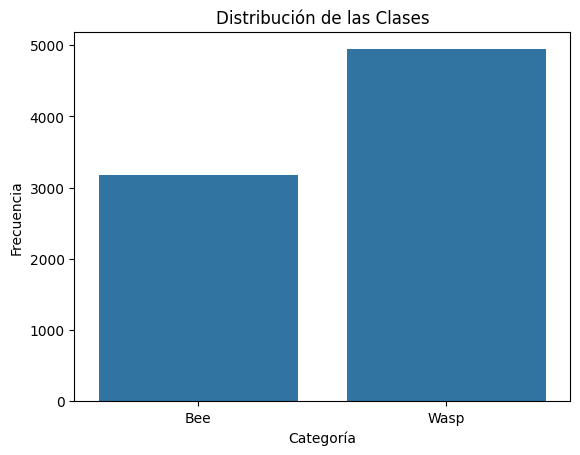

In [6]:
# Visualizar la distribución de las clases
sns.countplot(x='category', data=labels)
plt.title('Distribución de las Clases')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.xticks([0, 1], ['Bee', 'Wasp'])
plt.show()

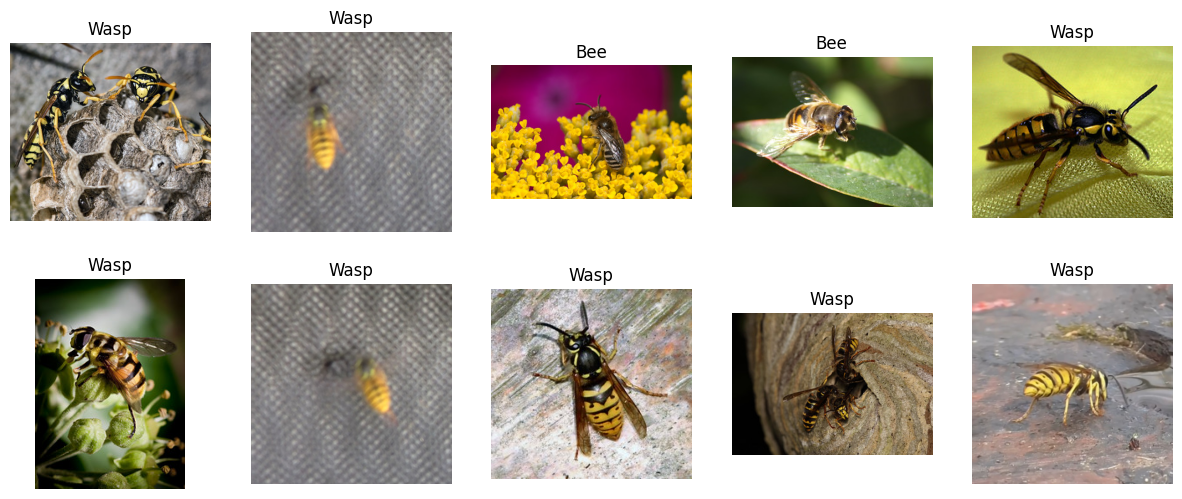

In [7]:
# Visualizar algunas imágenes
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, (idx, row) in enumerate(labels.sample(10).iterrows()):
    img = plt.imread(row['path'])
    ax = axes[i//5, i%5]
    ax.imshow(img)
    ax.set_title('Bee' if row['category'] == 0 else 'Wasp')
    ax.axis('off')
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

# Dividir el conjunto de datos en entrenamiento y validación manteniendo la proporción de clases
train_df, val_df = train_test_split(labels, test_size=0.2, stratify=labels['category'], random_state=42)



# Crear generadores de datos con los nuevos DataFrames

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='.',  
    x_col='path',
    y_col='category',
    target_size=(100, 100),
    batch_size=32,
    class_mode='raw',
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='.',  
    x_col='path',
    y_col='category',
    target_size=(100, 100),
    batch_size=32,
    class_mode='raw',
)


Found 6500 validated image filenames.
Found 1626 validated image filenames.


In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Definir la red neuronal convolucional con regularización y ajuste de la tasa de aprendizaje
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


# Compilar el modelo con una tasa de aprendizaje ajustada
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

c:\Users\TANIA CUSTUZA\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,650,433 (10.11 MB)

 Trainable params: 2,650,433 (10.11 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Configurar callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')



In [11]:
# Verificar la distribución de las etiquetas en los conjuntos de entrenamiento y validación
train_labels = train_generator.labels
val_labels = validation_generator.labels
print(f'Distribución de etiquetas en entrenamiento: {np.unique(train_labels, return_counts=True)}')
print(f'Distribución de etiquetas en validación: {np.unique(val_labels, return_counts=True)}')

Distribución de etiquetas en entrenamiento: (array([0, 1], dtype=int64), array([2546, 3954], dtype=int64))
Distribución de etiquetas en validación: (array([0, 1], dtype=int64), array([637, 989], dtype=int64))


In [12]:
# Entrenar el modelo
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100


c:\Users\TANIA CUSTUZA\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


204/204 ━━━━━━━━━━━━━━━━━━━━ 66s 307ms/step - accuracy: 0.5690 - loss: 2.0930 - val_accuracy: 0.7540 - val_loss: 1.3920
Epoch 2/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 58s 281ms/step - accuracy: 0.7612 - loss: 1.2810 - val_accuracy: 0.8143 - val_loss: 1.0411
Epoch 3/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 65s 314ms/step - accuracy: 0.8256 - loss: 0.9947 - val_accuracy: 0.8389 - val_loss: 0.8667
Epoch 4/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 56s 270ms/step - accuracy: 0.8513 - loss: 0.8436 - val_accuracy: 0.8383 - val_loss: 0.7878
Epoch 5/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 55s 265ms/step - accuracy: 0.8484 - loss: 0.7675 - val_accuracy: 0.8450 - val_loss: 0.7317
Epoch 6/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 54s 259ms/step - accuracy: 0.8456 - loss: 0.7239 - val_accuracy: 0.8413 - val_loss: 0.6907
Epoch 7/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 54s 260ms/step - accuracy: 0.8564 - loss: 0.6670 - val_accuracy: 0.8512 - val_loss: 0.6570
Epoch 8/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 53s 259ms/step - accuracy: 0.8650 - loss: 0.632

In [13]:
# Evaluar el modelo
val_labels = validation_generator.labels
val_preds = (model.predict(validation_generator) > 0.5).astype("int32")

51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step


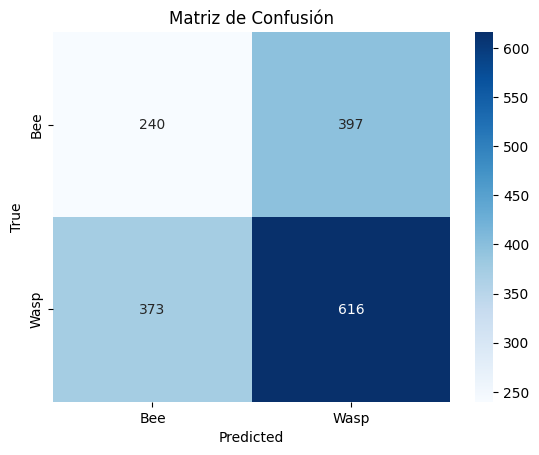

In [14]:
# Matriz de confusión
conf_matrix = confusion_matrix(val_labels, val_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Bee', 'Wasp'], yticklabels=['Bee', 'Wasp'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()

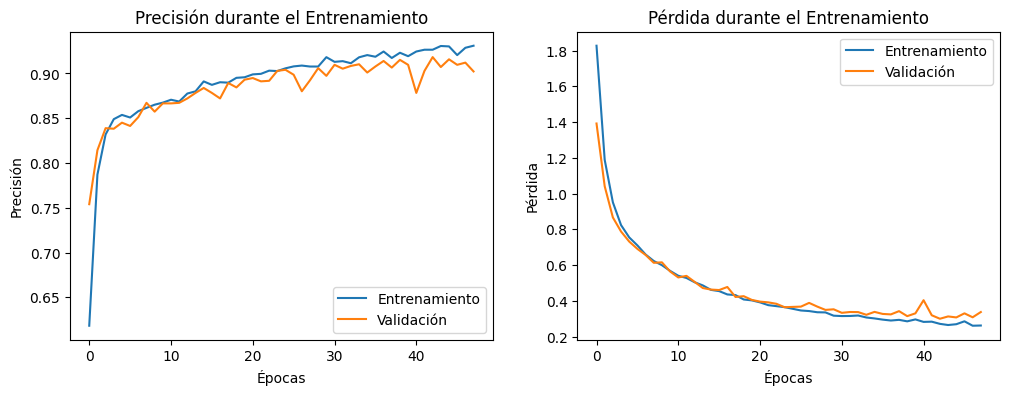

In [15]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

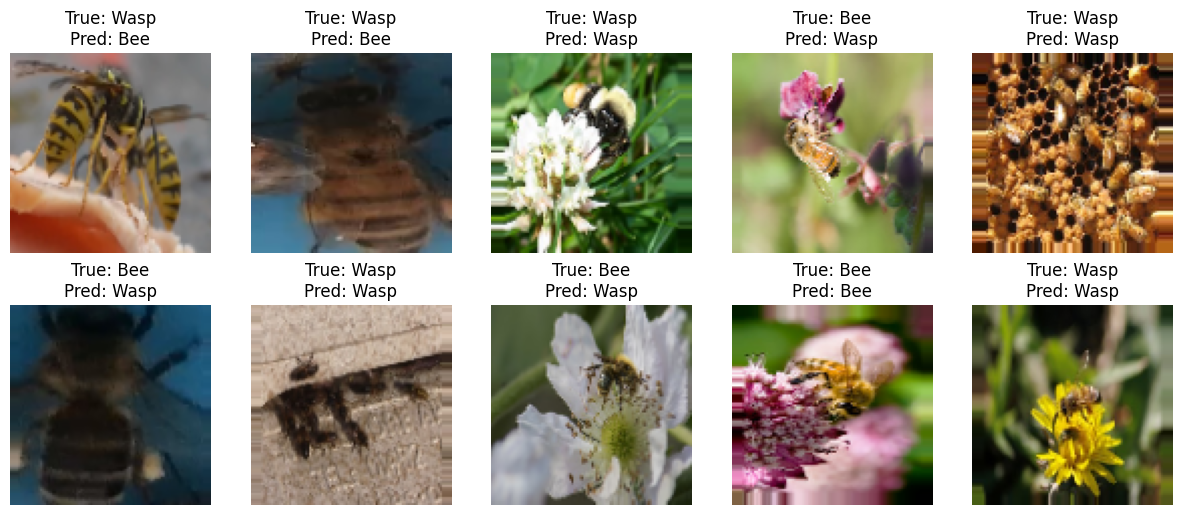

In [16]:
# Visualizar predicciones
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, (img, true_label, pred_label) in enumerate(zip(validation_generator[0][0], val_labels[:10], val_preds[:10])):
    ax = axes[i//5, i%5]
    ax.imshow(img)
    ax.set_title(f'True: {"Bee" if true_label == 0 else "Wasp"}\nPred: {"Bee" if pred_label == 0 else "Wasp"}')
    ax.axis('off')
plt.show()